# PyLAR
## [Python utilities for the LAR model](https://github.com/seap-udea/pylar)

## Figures for the LAR-SMZG-HESS2024

Use this notebook to generate the figures of the paper:

> Juan F. Salazar, Rubén D. Molina, Jorge I. Zuluaga, and Jesus D. Gomez-Velez (2024), **Wetting and drying trends in the land–atmosphere reservoir of large basins around the world**, [Hydrology and Earth System Sciences, in publication (2024)](https://hess.copernicus.org/preprints/hess-2023-172/), [doi.org/10.5194/hess-2023-172](https://doi.org/10.5194/hess-2023-172).


In [19]:
import ipylar as lar
%load_ext autoreload 
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figures: comparison against GRACE data

### Required packages and data

In [2]:
#External packages
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict as Dict
from scipy.interpolate import interp1d
import mpmath as mp
import numpy as np
from datetime import datetime,timedelta
import pytz
import matplotlib.dates as mdates
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from scipy.signal import lombscargle
from scipy.optimize import minimize
from scipy import signal as sg
import sympy as sp
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.integrate import trapezoid
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.stats import multivariate_normal
from matplotlib.ticker import FormatStrFormatter
from matplotlib.font_manager import FontProperties
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib

### Useful constants and routines

In [3]:
COLAB=0
#Constants
rad=180/np.pi
deg=1/rad
UTCL=5*3600
hours=3600
days=86400
years=365.25*days

#Data source
lar_figdir="figures/"
lar_datadir="data/"

#Safe colors
Qcolor="#d95f02"
Rcolor="#7570b3"

#Common strings
nam_nablaq="Moisture convergence"
str_nablaq=r"$Q$"
nam_R="River discharge"
str_R=r"$R$"
sty_nq=dict(color=Rcolor,alpha=1)
sty_R=dict(color=Qcolor,alpha=1)
lab_nq=rf"{nam_nablaq} ({str_nablaq})"
lab_R=rf"{nam_R} ({str_R})"

#Units
nam_flu="Flux"
UQ=1e9/(365.25*86400) #dam^3 -> m^3
uflux=r"$10^3$ km$^3$/yr"
#Time
utime="d"
UT=1
#Total stored
UI=1e3 #km^3 -> 10^3 km^3

# Accumulation, release
acc_color='#66c2a5'
rel_color='#fc8d62'

def figsize(sx,sy):
    if COLAB:
        DPIX=2
        DPIY=1
    else:
        DPIX=1
        DPIY=1
    return (sx*DPIX,sy*DPIY)

def tight_layout(fig):
    fig.tight_layout()
    
def save_fig(fig):
    try:
        print(f"Saving plot as '{fig.name}'")
        fig.savefig(f"{lar_figdir}/{fig.name}")
    except:
        pass
    
def set_xdates(ax):
    locator=mdates.AutoDateLocator(minticks=5,maxticks=50)
    formatter=mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x',rotation=90)
    ax.margins(0)
    
class Basin(object):
    def __init__(self):
            pass

def trapezoid_int(f,a,b,dx):
    xs=np.arange(a,b+dx/2,dx)
    ys=f(xs)
    I=trapezoid(ys,xs)
    return I

### Reading data

In [20]:
#############################################
#BASINS
#############################################
# Areas in km^2
basin_data=Dict(
    amazonas=Dict(name="Amazon basin",qsrc="ERA5",rsrc="HYBAM",drgs=[1997,2001,2005,2007,2010,2015],area=4690963),
    parana=Dict(name="Parana basin",qsrc="ERA5",rsrc="GRDC",drgs=[],area=2527003),
    congo=Dict(name="Congo basin",qsrc="ERA5",rsrc="GRDC",drgs=[],area=3634880),
    mississippi=Dict(name="Mississippi basin",qsrc="ERA5",rsrc="GRDC",drgs=[],area=2914994),
    ob=Dict(name="Ob basin",qsrc="ERA5",rsrc="GRDC",drgs=[],area=2441939),
    yenisei=Dict(name="Yenisei basin",qsrc="ERA5",rsrc="GRDC",drgs=[],area=2419867),
)
bmap=list(matplotlib.colormaps['Set1'].colors)
bmap.remove(bmap[5])
for i,basin in enumerate(basin_data.keys()):
    basin_data[basin]["color"]=bmap[i]

In [8]:
def time_interpolation_function(times,values):
    interp_basic = interp1d(times,values,kind='slinear')
    def interp_fun(t):
        if interp_basic.x[0]<t<interp_basic.x[-1]:
            return interp_basic(t)
        else:
            return np.nan
    return interp_fun

def read_basin_data(key,full,qsource,rsource,kind_interp='linear'):
    
    #Create basin
    basin=Basin()
    basin.key=key
    basin.full=full
    basin.qsource=qsource
    basin.rsource=rsource
    
    #Read Data
    source=f"era5/{basin.key}_output.csv"
    data=pd.read_csv(f"{lar_datadir}/{source}")
    
    #Average of divergence over 3 hours
    fackg=3*hours*1e3
    
    #Read errors
    source=f"vimd/{basin.key}_monthly.csv"
    data_errors=pd.read_csv(f"{lar_datadir}/{source}",index_col=0)
    data_errors["nqdiv"]=data_errors.ensemble_mean/fackg
    data_errors["dnqdiv"]=data_errors.ensemble_spread/fackg
    data_errors["relerr"]=data_errors.ensemble_spread/abs(data_errors.ensemble_mean)
    data_errors["date"]=data_errors.apply(lambda row:f"{row.year:.0f}-{row.month:.0f}-16",axis=1)
    data_errors["datestd_err"]=data_errors["date"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d").strftime("%Y-%m-16"))
    data_errors["datetime"]=data_errors["datestd_err"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d"))
    data_errors["time"]=data_errors["datetime"].apply(lambda d:d.timestamp()+UTCL)
    data_errors.set_index("datestd_err",drop=False,inplace=True)
    columns_err=["time","datestd_err","nqdiv","dnqdiv","relerr"]
    
    #Dates
    data["datestd"]=data["date"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d").strftime("%Y-%m-16"))
    data["datetime"]=data["datestd"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d"))
    data["time"]=data["datetime"].apply(lambda d:d.timestamp()+UTCL)
    
    #Numeric columms
    columns=['water_vap','water_liq','water_ice']
    data.dropna(subset=columns,inplace=True)
    try:
        for col in columns:
            data[col]=data[col].str.replace(",",".").astype("float")
    except:
        pass
    for col in columns:
        data[col]=pd.to_numeric(data[col],errors='coerce').interpolate()
    #Consolidate columns
    data_atm=data.copy()
    data_atm.set_index(data["datestd"],inplace=True)
    data_atm["nq_mass"]=data_atm[columns].sum(axis=1)
    data_atm["nq"]=data_atm["nq_mass"]/1e3
    #Error
    vnq=0.05 #Molina, according to analysis of uncertainties in data processing of ERA5
    data_atm["dnq"]=vnq*data_atm["nq_mass"]

    if basin.rsource == "GRDC":
        #Read Data
        source=f"era5/{basin.key}_output.csv"
        data=pd.read_csv(f"{lar_datadir}/{source}")
        #Dates
        data["datestd"]=data["date"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d").strftime("%Y-%m-16"))
        columns=["discharge"]
    elif basin.rsource == "HYBAM":
        #Only for Amazon River
        RSOURCE="HYBAM"
        source=f"era5/{basin.key}_hybam_output.xlsx"
        data=pd.read_excel(f"{lar_datadir}/{source}")
        data["datestd"]=data.apply(lambda x:f"{x.V1:.0f}-{x.V2:02.0f}-16",axis=1)
        columns=["V4"]

    #Date
    data["datetime"]=data["datestd"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d"))
    data["time"]=data["datetime"].apply(lambda d:d.timestamp()+UTCL)
    
    #Numeric columns
    data.dropna(subset=columns,inplace=True)
    try:
        for col in columns:
            data[col]=data[col].str.replace(",",".").astype("float")
    except:
        pass
    for col in columns:
        data[col]=pd.to_numeric(data[col],errors='coerce').interpolate()
    #Consolidate data
    data_riv=data.copy()
    data_riv.set_index(data["datestd"],inplace=True)
    data_riv["R"]=data_riv[columns].sum(axis=1)
    
    #Error
    vR=0.15 #According to T. H. Syed, J. S. Famiglietti, et al. (in case of Amazonas)
    data_riv["dR"]=vR*data_riv["R"]

    # Merge data
    data_merge=pd.DataFrame()
    merge=data_atm.merge(data_riv,left_index=True,right_index=True)
    data_merge["datestd"]=merge["datestd_x"]
    data_merge.set_index(data_merge["datestd"],inplace=True)
    data_merge["datetime"]=merge["datetime_x"]
    data_merge["time"]=merge["time_x"]
    data_merge["R"]=merge["R"]
    data_merge["dR"]=merge["dR"]
    data_merge["nq"]=merge["nq"]
    data_merge["dnq"]=merge["dnq"]

    #Reference
    data_merge["Rref"]=merge["R"]
    data_merge["nqref"]=merge["nq"]
    
    # Save data
    basin.data_merge=data_merge
    #basin.data=data_merge
    basin.columns_err=columns_err
    basin.data=pd.merge(data_merge,data_errors[columns_err],how="left",on="time")
    basin.data.set_index("datestd",drop=False,inplace=True)
    basin.tini=float(data_merge["time"].iloc[0])
    basin.tend=float(data_merge["time"].iloc[-1])
    basin.dini=data_merge["datetime"].iloc[0]
    basin.tspan=data_merge["time"].iloc[-1]-data_merge["time"].iloc[0]
    basin.yspan=basin.tspan/years
    basin.dspan=basin.tspan/days
    basin.data_errors=data_errors

    #Global properties
    basin.ndata=len(data_merge)
    basin.nmerge=len(data_merge)
    basin.nerror=len(data_errors[(data_errors.time>=basin.tini)&(data_errors.time<=basin.tend)])
    basin.vnq=vnq
    basin.vR=vR

    #Correlation
    """
    Cov = 
    [ 
    sigma_x^2  rho_xy sigma_x sigma _y
    rho_xy sigma_x sigma _y  sigma_y^2
    ]
    """
    Cov=np.cov(basin.data["R"],basin.data["nq"])
    """
    rho_xy = Cov[0,1]/(sigma_x*sigma_y)
    sigma_x = Cov[0,0]**0.5
    sigma_y = Cov[1,1]**0.5
    """
    basin.rhoRnq=Cov[0,1]/(Cov[0,0]*Cov[1,1])**0.5
    
    #Basin color
    basin.color=basin_data[key]["color"]
    
    #Detection
    basin.detection=False
    
    #Extract errors from data_errors
    basin.data.dnq=basin.data.dnqdiv
    basin.vnq=None
    
    #Random seed
    basin.seed=hash(basin)%(2**32-1)
    
    #Data global properties
    print(f"*"*40)
    print(f"{basin.key}")
    print(f"Number of data points: merge = {basin.nmerge}, error = {basin.nerror}, total = {basin.ndata}")
    print(f"Initial time: {basin.tini}")
    print(f"Initial date: {basin.dini}")
    print(f"Total data points: {basin.ndata}")
    print(f"Time span: {basin.yspan} a = {basin.dspan} d")
    print(f"Signal correlation (R - nq): {basin.rhoRnq}")
    
    return basin

def plot_basin_series(basin,ti_win=2000,dt_win=5,kind_interp='cubic',over_interp=10,show_ref=False):

    #Interpolation
    basin.Rint=interp1d(basin.data["time"],basin.data["R"],kind=kind_interp)
    basin.nqint=interp1d(basin.data["time"],basin.data["nq"],kind=kind_interp)
    
    #Full signal
    tfulls=np.linspace(basin.data["time"].iloc[0],basin.data["time"].iloc[-1],over_interp*basin.ndata)
    dfulls=[datetime.fromtimestamp(t) for t in tfulls]
    Rfulls=basin.Rint(tfulls)
    nqfulls=basin.nqint(tfulls)

    #Plot full signal
    fig,axs=plt.subplots(2,1,figsize=figsize(9,8))

    #Full panel
    ax=axs[0]

    ax.plot(basin.data["datetime"],basin.data["nq"]/UQ/UI,label=lab_nq,**sty_nq)
    ax.plot(basin.data["datetime"],basin.data["R"]/UQ/UI,label=lab_R,**sty_R)

    if show_ref:
        ax.plot(basin.data["datetime"],basin.data["nqref"]/UQ/UI,label=f"{str_nablaq} ref.",**sty_nq,ls=':')
        ax.plot(basin.data["datetime"],basin.data["R"]/UQ/UI,label=f"{str_R} ref.",**sty_R,ls=":")
        
    ax.set_ylabel(f"Flux [{uflux}]");
    legend=ax.legend(loc=(0.0,1),ncol=6,frameon=False);

    #Zoom
    ax=axs[1]
    ax.plot(dfulls,nqfulls/UQ/UI,label=rf"{nam_R} ({str_R})",**sty_nq)
    ax.errorbar(basin.data["datetime"],basin.data["nq"]/UQ/UI,yerr=basin.data["dnq"]/UQ/UI,ls='None',capsize=5,**sty_nq)
    ax.plot(dfulls,Rfulls/UQ/UI,label=rf"{nam_R} ({str_R})",**sty_R)
    ax.errorbar(basin.data["datetime"],basin.data["R"]/UQ/UI,yerr=basin.data["dR"]/UQ/UI,ls='None',capsize=5,**sty_R)
    
    if show_ref:
        #Interpolation
        basin.Rint=interp1d(basin.data["time"],basin.data["Rref"],kind=kind_interp)
        basin.nqint=interp1d(basin.data["time"],basin.data["nqref"],kind=kind_interp)

        #Full signal
        tfulls=np.linspace(basin.data["time"].iloc[0],basin.data["time"].iloc[-1],over_interp*basin.ndata)
        dfulls=[datetime.fromtimestamp(t) for t in tfulls]
        Rfulls=basin.Rint(tfulls)
        nqfulls=basin.nqint(tfulls)

        ax.plot(dfulls,nqfulls/UQ/UI,**sty_nq,ls=":")
        ax.errorbar(basin.data["datetime"],basin.data["nqref"]/UQ/UI,yerr=basin.data["dnq"]/UQ/UI,ls='None',capsize=5,**sty_nq)
        ax.plot(dfulls,Rfulls/UQ/UI,**sty_R,ls=":")
        ax.errorbar(basin.data["datetime"],basin.data["Rref"]/UQ/UI,yerr=basin.data["dR"]/UQ/UI,ls='None',capsize=5,**sty_R)

    ax.set_ylabel(f"Flux [{uflux}]");
    ti_win=datetime(ti_win,1,1)
    dt_win=relativedelta(years=dt_win)
    ax.set_xlim(ti_win,ti_win+dt_win)

    #Source
    ax.text(0.98,0.98,f"Source: {basin.rsource}/{basin.qsource}",
            ha='right',va='top',transform=ax.transAxes,fontsize=8)

    #Decoration
    for ax in axs:
        locator=mdates.AutoDateLocator(minticks=5,maxticks=50)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=90)
        ax.margins(0)

    axs[0].set_title(f"{basin.full}",pad=30)
    fig.name=f"{basin.key}-full_signal.png"
    tight_layout(fig);  

def modify_basin_errors(basin,vnq=None,vR=None):
    """
    Default values:
        vnq=0.05 #Molina, according to analysis of uncertainties in data processing of ERA5
        vR = 0.15 #According to T. H. Syed, J. S. Famiglietti, et al. (in case of Amazonas)
    """   
    basin.vnq=vnq
    basin.vR=vR
    if vnq:
        basin.data["dnq"]=vnq*abs(basin.data["nq"])
    if vR:
        basin.data["dR"]=vR*abs(basin.data["R"])
        
def basin_storage(basin,ts):
    n=len(ts)
    kind_interp="linear"
    basin.Rint=interp1d(basin.data["time"],basin.data["R"],kind=kind_interp)
    basin.nqint=interp1d(basin.data["time"],basin.data["nq"],kind=kind_interp)
    AlmFun=lambda t:basin.nqint(t)-basin.Rint(t)
    Is=np.array([trapezoid_int(AlmFun,ts[i],ts[i+1],days)/1e9 for i in range(n-1)])
    Ss=np.cumsum(Is)
    ts=(ts[1:]+ts[:-1])/2
    return ts,Is,Ss

In [9]:
basins=dict()
for key in basin_data.keys():
    basins[key]=read_basin_data(key,
                                basin_data[key]["name"],
                                basin_data[key]["qsrc"],
                                basin_data[key]["rsrc"])    

****************************************
amazonas
Number of data points: merge = 492, error = 492, total = 492
Initial time: 285310800.0
Initial date: 1979-01-16 00:00:00
Total data points: 492
Time span: 40.91444216290212 a = 14944.0 d
Signal correlation (R - nq): -0.091294406770398
****************************************
parana
Number of data points: merge = 428, error = 428, total = 428
Initial time: 285310800.0
Initial date: 1979-01-16 00:00:00
Total data points: 428
Time span: 35.58110882956879 a = 12996.0 d
Signal correlation (R - nq): -0.017824839827840985
****************************************
congo
Number of data points: merge = 384, error = 384, total = 384
Initial time: 285310800.0
Initial date: 1979-01-16 00:00:00
Total data points: 384
Time span: 31.915126625598905 a = 11657.0 d
Signal correlation (R - nq): 0.34386320649854707
****************************************
mississippi
Number of data points: merge = 504, error = 504, total = 504
Initial time: 285310800.0
Initi

The units of R and Q in the original files are in dam

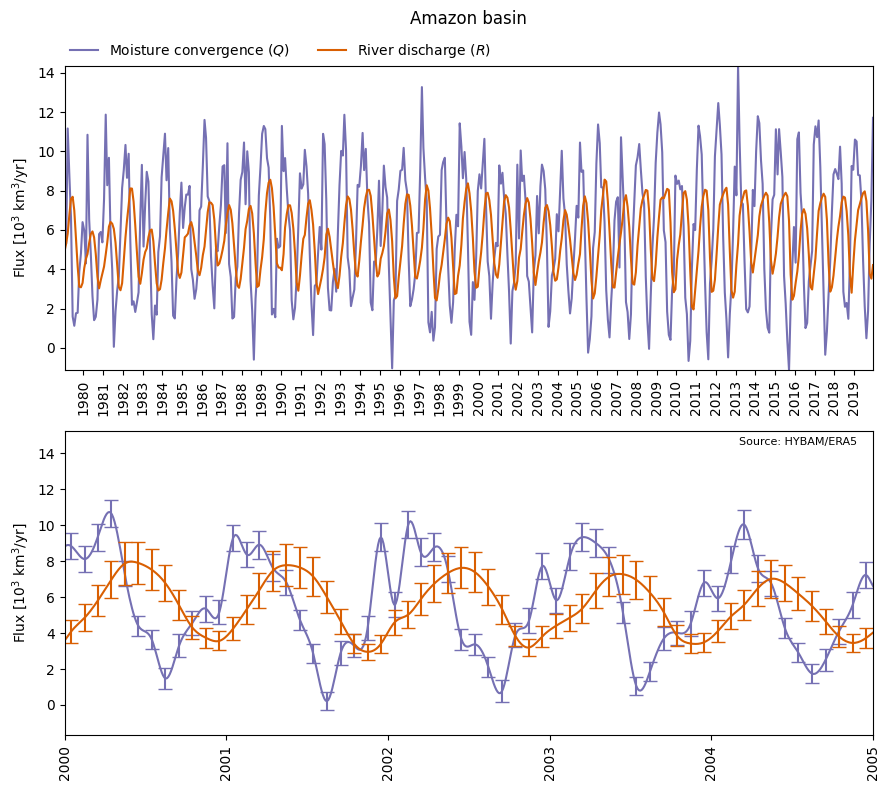

In [10]:
plot_basin_series(basins["amazonas"])

### Basin additional information

We can compute the rate of change of atmospheric storage from a balance between the moisture convergence ($Q$), precipitation ($P$) and evotranspiration ($E$). 
$$
\frac{dS_A}{dt_n}^{\mathrm{(mod)}} = Q_n - P_n + E_n \;\;[\mathrm{km}^3/\mathrm{s}]
$$
here the subindex $n$ stands for each entry in the time-series of the corresponding quantities as obtained from the reanalysis of atmospheric data. We call this the model estimate. 

On the other hand,  the change in the land-atmosphere reservoir (LAR) is the sum of the atmospheric and land contributions: 
$$
\frac{dS_{LAR}}{dt_n} = \frac{dS_A}{dt_n} + \frac{dS_L}{dt_n} \;\;[\mathrm{km}^3/\mathrm{s}]
$$

From here we can obtain an independent rate of change in the atmospheric storage. We call the *consistency estimate* and it is given by:  
$$
\frac{dS_A}{dt_n}^{\mathrm{(cons)}} = \frac{dS_{LAR}}{dt_n} - \frac{dS_L}{dt_n} = Q_n - R_n - \frac{dS_L}{dt_n}
$$

Total water storage (TWS) is the total amount of water stored in a given area on Earth over a period of time given by GRACE's temporal resolution. GRACE provide the anomaly $\mathrm{TWS}' = \mathrm{TWS} - \mathrm{TWS}_0$, where $\mathrm{TWS}_0$ is an unknown value. If we want to compute the variation in the storage we need to calculate:
$$
\frac{dS_L}{dt_n} = \frac{d(\mathrm{TWS})}{dt_n} = \frac{\mathrm{TWS}_n - \mathrm{TWS}_{n-1}}{t_n-t_{n-1}} = \frac{\mathrm{TWS}'_n - \mathrm{TWS}'_{n-1}}{t_n-t_{n-1}} \;\;[\mathrm{cm/month}]
$$

Other way to compare is to calculate the water vapor coming from the ground:

$$
\frac{dS_G}{dt} \equiv \frac{dS_A}{dt} - Q
$$

so, we need to compare

$$
\frac{dS_G}{dt_n}^{\mathrm{(cons)}} = - R_n - \frac{dS_L}{dt_n}
$$
$$
\frac{dS_G}{dt_n}^{\mathrm{(mod)}} = - P_n + E_n
$$





Loading GRACE data:

In [18]:
#LWE_FACTOR = (1/1e3)**3/1e3 # From m^3 -> x10^3 km^3
LWE_FACTOR = 1
for basin_name in basin_data.keys():
    basin_denom = basin_name
    if basin_name == 'amazon':
        basin_denom = 'amazonas'
    basin_table = basins[basin_denom].data

    # GRACE data
    print(f"Loading GRACE data for basin '{basin_name}'...")
    dataprods = ['gsfc','utexas']
    for dataprod in dataprods:
        tws_file = f"{lar_datadir}/grace/{basin}_grace_{dataprod}_m3.csv"
        data = pd.read_csv(tws_file)
        data['datestd'] = data['time']
        data["datetime"]=data["time"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d"))
        data["time"]=data["datetime"].apply(lambda d:d.timestamp()+UTCL)
        data['lwe_thickness'] = data.lwe_thickness*LWE_FACTOR
        interp_fun = time_interpolation_function(data.time,data.lwe_thickness)
        basin_table[f"lwe_{dataprod}"] = basin_table.apply(lambda row:interp_fun(row["time"]),axis=1)
        # Basin rate of TWS
        lwe = np.array(data.lwe_thickness)
        ts = np.array(data.time)
        dSLdt = (lwe[1:]-lwe[:-1])/(ts[1:]-ts[:-1])
        data['dSLdt'] = np.concatenate([[np.nan],dSLdt])
        interp_fun = time_interpolation_function(data.time[1:],dSLdt)
        # Rates 
        basin_table[f"dSL_dt_{dataprod}"] = basin_table.apply(lambda row:interp_fun(row["time"]),axis=1)
        basin_table['dSLAR_dt'] = basin_table.nq - basin_table.R
        basin_table[f"dSAcons_dt_{dataprod}"] = basin_table.dSLAR_dt - basin_table[f"dSL_dt_{dataprod}"]
        basin_table[f"dSGcons_dt_{dataprod}"] = -basin_table.R - basin_table[f"dSL_dt_{dataprod}"]
    #break

Loading GRACE data for basin 'amazonas'...
Loading GRACE data for basin 'parana'...
Loading GRACE data for basin 'congo'...
Loading GRACE data for basin 'mississippi'...
Loading GRACE data for basin 'ob'...
Loading GRACE data for basin 'yenisei'...


### Paper figure

/tmp/ipykernel_71147/2656834087.py:81: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_71147/2656834087.py:81: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


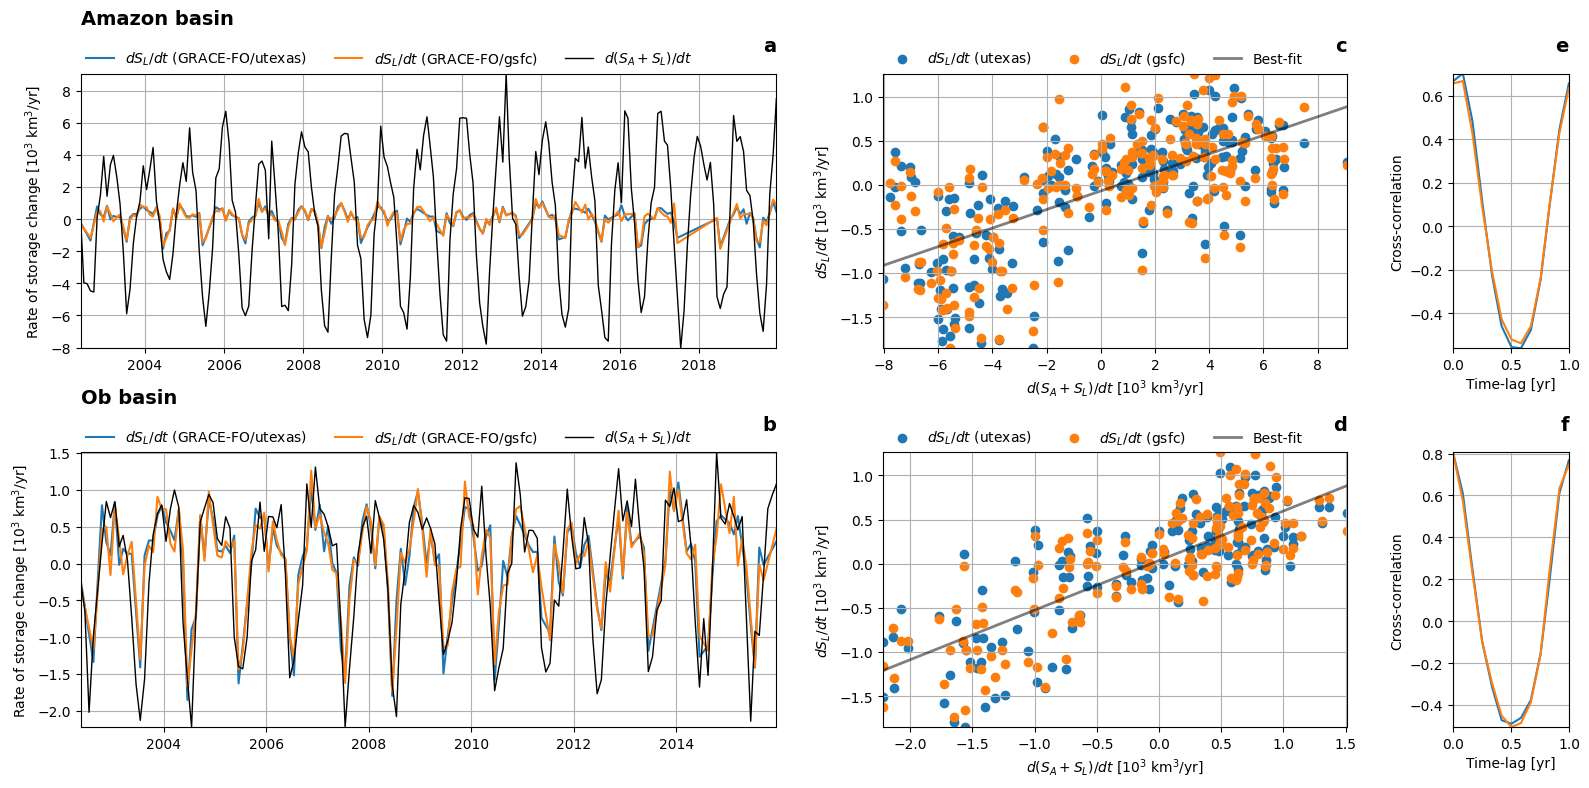

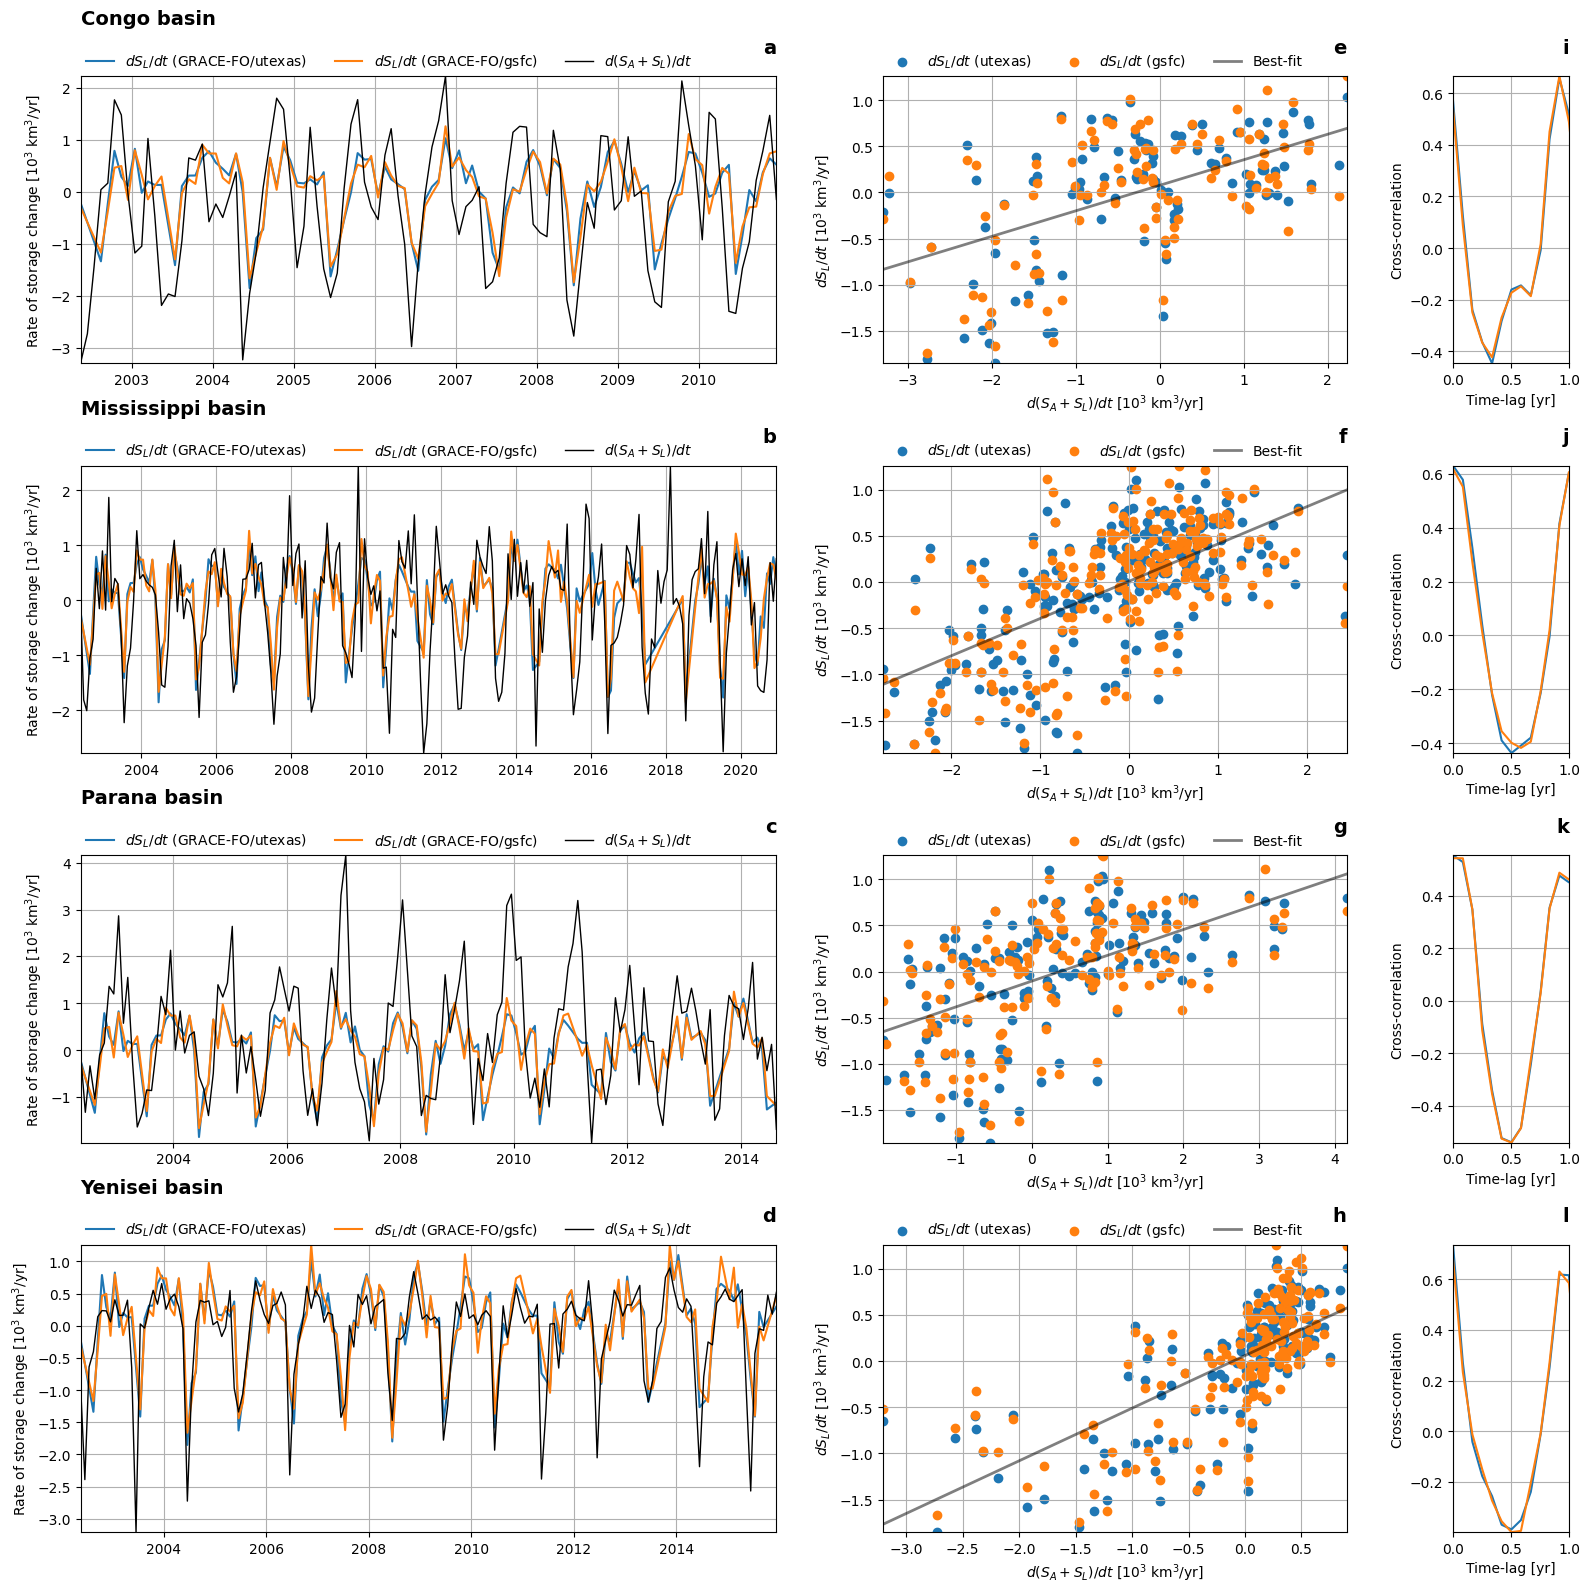

In [17]:
for basins_list in ['amazonas','ob'],['congo','mississippi','parana','yenisei']:
    nbasins = len(basins_list)

    width = 16
    height = 4*nbasins
    fig,baxs = plt.subplots(nbasins,1,figsize=(width,height),layout='constrained')
    for bax in baxs:
        bax.set_axis_off()
        pass
    gs = fig.add_gridspec(nbasins,3,width_ratios=[3,2,0.5])

    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

    il = 0 
    for i,basin_name in enumerate(basins_list): 

        basin_table = basins[basin_name].data
        basin_full = basins[basin_name].full

        # Plot Fluxes
        ax = fig.add_subplot(gs[i,0])
        ax.text(0,1.2,f"{basin_full}",transform=ax.transAxes,ha='left',va='center',fontsize=14,fontweight='bold')
        
        # Panel labelling
        ax.text(1,1.1,letters[i],transform=ax.transAxes,ha='right',va='center',fontsize=14,fontweight='bold')

        dataprods = ['utexas','gsfc']
        for dataprod in dataprods:
            cond = (basin_table[f"dSL_dt_{dataprod}"].notna())
            ax.plot(basin_table.datetime[cond],basin_table[cond][f"dSL_dt_{dataprod}"]/UQ/UI,label=rf"$dS_L/dt$ (GRACE-FO/{dataprod})")
            
        ax.plot(basin_table.datetime[cond],basin_table[cond][f"dSLAR_dt"]/UQ/UI,label=rf"$d(S_{{A}}+S_{{L}})/dt$",color='k',ls='-',lw=1)

        ax.legend(loc=(0.0,1),ncol=6,frameon=False)
        ax.margins(0)
        ax.grid()
        ax.set_ylabel(rf"Rate of storage change [{uflux}]")
        
        # Plot correlation
        ax = fig.add_subplot(gs[i,1])
        for dataprod in dataprods:
            cond = basin_table[f"dSL_dt_{dataprod}"].notna()
            ax.scatter(basin_table[cond][f"dSLAR_dt"]/UQ/UI,basin_table[cond][f"dSL_dt_{dataprod}"]/UQ/UI,label=rf"$dS_L/dt$ ({dataprod})")
        ax.set_xlabel(rf"$d(S_{{A}}+S_{{L}})/dt$ [{uflux}]")
        ax.set_ylabel(rf"$dS_{{L}}/dt$ [{uflux}]")
        
        # Panel labelling
        ax.text(1,1.1,letters[i+nbasins-1+1],transform=ax.transAxes,ha='right',va='center',fontsize=14,fontweight='bold')
        
        ax.margins(0)

        x = basin_table[cond][f"dSLAR_dt"]/UQ/UI
        y = basin_table[cond][f"dSL_dt_{dataprod}"]/UQ/UI
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A.astype('float'), y.astype('float'), rcond=None)[0]
        xs = np.linspace(np.min(x),np.max(x),100)
        ys = m*xs + c
        ax.plot(xs,ys,color='k',ls='-',lw=2,alpha=0.5,label='Best-fit')
        ax.legend(loc=(0.0,1),ncol=6,frameon=False)
        ax.grid()
        
        # Cross-correlation coefficient
        ax = fig.add_subplot(gs[i,2])
        for dataprod in dataprods:
            cond = basin_table[f"dSL_dt_{dataprod}"].notna()
            cc = sm.tsa.stattools.ccf(basin_table[cond][f"dSLAR_dt"],basin_table[cond][f"dSL_dt_{dataprod}"],adjusted=False)
            ts = basin_table[cond].time - basin_table[cond].time.iloc[0]
            # Plot
            ax.plot(ts/86400/365.25,cc,label=f"{dataprod}, max CC = {np.max(cc):.2f}")
        ax.margins(0)
        ax.set_xlabel("Time-lag [yr]")
        ax.set_ylabel("Cross-correlation")
        ax.set_xlim(0,1)
        ax.grid()

        # Panel labelling
        ax.text(1,1.1,letters[i+2*nbasins-2+2],transform=ax.transAxes,ha='right',va='center',fontsize=14,fontweight='bold')
        
        # break

    fig.tight_layout()
    basins_name = "_".join(basins_list)
    fig.savefig(f"{lar_figdir}/dSLdt_dSLARdt_comparison_{basins_name}.png")